In [63]:
# Check Python Version
from platform import python_version

print(python_version())

3.8.13


In [64]:
from functools import partial
import time
import psutil
import GPUtil

## Get CPU information
cpu_count = psutil.cpu_count(logical=False)
cpu_freq = psutil.cpu_freq().current
cpu_total_size = psutil.virtual_memory().total / (1024**3)

## Get GPU information
gpus = GPUtil.getGPUs()
gpu_count = len(gpus)
gpu_total_size = sum([gpu.memoryTotal for gpu in gpus]) / (1024**3)

## Get RAM information
total_ram = psutil.virtual_memory().total / (1024 ** 3)

## Print
print(f"CPU count: {cpu_count}")
print(f"CPU frequency: {cpu_freq} GHz")
print(f"CPU total size: {cpu_total_size:.2f} GB")
print(f"GPU count: {gpu_count}")
print(f"GPU total size: {gpu_total_size:.2f} GB")
print(f"Total RAM: {total_ram:.2f} GB")

CPU count: 40
CPU frequency: 3866.2455 GHz
CPU total size: 376.40 GB
GPU count: 0
GPU total size: 0.00 GB
Total RAM: 376.40 GB


In [65]:
# Parallel Programming
import multiprocessing
from functools import partial
import time
from p_tqdm import p_map

In [66]:
# Filter Warning
import warnings
warnings.filterwarnings('ignore')

In [67]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pickle

# 1. Load Data

In [68]:
G1 = nx.read_gpickle("Data/Graphs/G1_bt.gpickle")
G2 = nx.read_gpickle("Data/Graphs/G2_bt.gpickle")

In [7]:
antipro_index = np.concatenate((np.arange(0, 317, 1), np.arange(1202, 1326, 1)), dtype = int) 

In [8]:
size_arr1 = np.array(list(nx.get_node_attributes(G1, 'fan_size').values()))[antipro_index]  # Feb fan size
size_arr2 = np.array(list(nx.get_node_attributes(G2, 'fan_size').values()))[antipro_index]  # Oct fan size

In [9]:
size_var = size_arr2 - size_arr1

# 3. SIR Model - Considering Bowtie

In [10]:
def select_initial_infector(G, bowtie_role, p_new_bowtie):
    
    dist = [p_new_bowtie[bowtie_role[k]] for k in list(G1.nodes)[:317] + list(G1.nodes)[1202:]]     
    dist /= np.sum(dist)
    n0 = np.random.choice(list(G1.nodes)[:317] + list(G1.nodes)[1202:], p = dist)

    return n0

In [11]:
def singleInfo(G, which_bowtie, p_new_bowtie, beta_bowtie, gamma_bowtie, seed = 0):
    
    # preprocess bowtie_role
    bowtie_role = dict(nx.get_node_attributes(G, which_bowtie))
    for k, v in bowtie_role.items(): 
        if v not in ['S', 'IN', 'OUT']:
            bowtie_role[k] = 'NA'
    
    np.random.seed(seed)
    
    # select initial infector
    n0 = select_initial_infector(G, bowtie_role, p_new_bowtie)
    state = {node:0 for node in G.nodes}; state[n0] = 1 # S:0, I:1, R:-1
    
    # Iteration
    counter = 0
    
    while np.sum(np.array(list(state.values())) == 1) != 0: # break if there is no infected node
        update_state = state.copy()
        
        for k in state.keys():
            # recover or not
            if state[k] == 1 and np.random.random(1)[0] < gamma_bowtie[bowtie_role[k]]:
                update_state[k] = -1
            
            # infect or not
            elif state[k] == 0:
                weight_sum = np.sum(np.array([G.nodes[edge[1]]['fan_size'] for edge in G.out_edges(k)]))
                weight_infect = np.sum(np.array([G.nodes[edge[1]]['fan_size'] for edge in G.out_edges(k) if state[edge[1]] == 1]))
                
                random_var = np.random.random(1)[0]
                
                if weight_sum != 0 and random_var < beta_bowtie[bowtie_role[k]] * weight_infect / weight_sum:
                    update_state[k] = 1
                    
        # end of this iteration        
        counter += 1
        state = update_state.copy()
        
        # prevent too many steps
        if counter > 1000:
            break
    
    # All of the recovered nodes except for n0
    epidemic_nodes = [k for k in state.keys() if state[k] == -1 and k!= n0]
    
    return n0, epidemic_nodes

In [12]:
def all_info(G, which_bowtie, p_new_bowtie, beta_bowtie, gamma_bowtie, iteration):
    n0_list, epidemic_nodes_list = [], []
    
    all_info_seed = partial(singleInfo, G1, which_bowtie, p_new_bowtie, beta_bowtie, gamma_bowtie)
    results = p_map(all_info_seed, np.arange(iteration))
    
    for i in range(iteration):
        n0, epidemic_nodes = results[i]
        n0_list.append(n0); epidemic_nodes_list.append(epidemic_nodes)
        
    return n0_list, epidemic_nodes_list

In [13]:
def cal_within_group_influ(n0_list, epidemic_nodes_list):
    
    influ = {node: 0 for node in list(G1.nodes)[:317] + list(G1.nodes)[1202:]}
    
    for i in range(len(n0_list)):
        n0 = n0_list[i]; epidemic_nodes = epidemic_nodes_list[i]
        influ[n0] += np.sum([G1.nodes[node]['fan_size'] for node in epidemic_nodes if node.startswith(n0[0])])
    
    return influ

In [14]:
def cal_across_group_influ(n0_list, epidemic_nodes_list):
    influ = {node: 0 for node in list(G1.nodes)[:317] + list(G1.nodes)[1202:]}
    
    for i in range(len(n0_list)):
        n0 = n0_list[i]; epidemic_nodes = epidemic_nodes_list[i]
        influ[n0] += np.sum([G1.nodes[node]['fan_size'] for node in epidemic_nodes if node.startswith('n')])
    
    return influ

In [15]:
from sklearn.feature_selection import mutual_info_regression
def cal_mutual_info_reg(features, target, discrete, times):
    dataset = []
    
    for i in range(times):
        #print(i)
        MI = mutual_info_regression(features, target, discrete_features = discrete, n_neighbors = 3)
        dataset.append(MI)
        
    return np.average(np.array(dataset), axis = 0)

In [16]:
from sklearn.feature_selection import mutual_info_regression
from scipy import stats

def cal_asso_with_fan_var(influ):
    
    influ_arr = np.array(list(influ.values()))
    
    coeff = np.corrcoef(influ_arr, size_var)[0, 1]
    
    spearmanr = stats.spearmanr(influ_arr, size_var)
    mi = cal_mutual_info_reg(influ_arr.reshape(-1, 1), size_var, discrete = False, times = 50)[0]
    
    return coeff, mi

In [17]:
def cal_asso_with_fan_expand(influ):
    
    influ_arr = np.array(list(influ.values()))
    
    coeff = np.corrcoef(influ_arr[size_var>0], size_var[size_var>0])[0, 1]
    mi = cal_mutual_info_reg(influ_arr[size_var > 0].reshape(-1, 1), size_var[size_var > 0], discrete = False, times = 50)
    
    spearmanr = stats.spearmanr(influ_arr[size_var>0], size_var[size_var>0])
    
    return coeff, mi

In [18]:
def cal_asso_with_fan_nonexpand(influ):
    
    influ_arr = np.array(list(influ.values()))
    
    coeff = np.corrcoef(influ_arr[size_var<=0], size_var[size_var<=0])[0, 1]
    mi = cal_mutual_info_reg(influ_arr[size_var<=0].reshape(-1, 1), size_var[size_var<=0], discrete = False, times = 50)[0]
    
    spearmanr = stats.spearmanr(influ_arr[size_var<=0], size_var[size_var<=0])
    
    return coeff, mi

In [19]:
def label_conversion(times):
    return ['$10^{' + str(i) + '}$' for i in times]

In [20]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap


orig_cmap = matplotlib.cm.coolwarm
shifted_cmap = shiftedColorMap(orig_cmap, start = 0, midpoint = 0.4, stop = 1, name='shift_cmap1')

## 3.1. Within-group Bowtie

- **Info Cascade Length**

In [81]:
def SIR_model(G, β = 0.3, ν = 0.2, bowtie = 'within_role', bowtie_role = 'OUT', seed = 0):
    
    np.random.seed(seed)
    
    # Pick an initial infector
    role_nodes = [node for node in list(G.nodes) if G.nodes[node][bowtie] == bowtie_role and G.nodes[node]['polarity'] != 'neutral'] 
    n_0 = np.random.choice(role_nodes)
    
    # Iteration
    counter = 0
    state = {node:0 for node in G.nodes}; state[n_0] = 1 # S:0, I:1, R:-1
    
    while np.sum(np.array(list(state.values())) == 1) != 0: # break if there is no infected node
        
        update_state = state.copy()
        
        for k in state.keys():
            
            # recover or not
            if state[k] == 1 and np.random.random(1)[0] < ν:
                update_state[k] = -1
    
            # infect or not
            elif state[k] == 0:
                weight_sum = np.sum(np.array([G.nodes[edge[1]]['fan_size'] for edge in G.out_edges(k)]))
                weight_infect = np.sum(np.array([G.nodes[edge[1]]['fan_size'] for edge in G.out_edges(k) if state[edge[1]] == 1]))
                
                random_var = np.random.random(1)[0]
                
                if weight_sum != 0 and random_var < β * weight_infect / weight_sum:
                    
                    update_state[k] = 1
                    
                    
        # end of this iteration        
        counter += 1
        state = update_state.copy()
        
        # prevent too many steps
        if counter > 1000:
            break
    
    
    # All of the recovered nodes
    R = np.array([k for k in state.keys() if state[k] == -1])
    
    return n_0, R

In [82]:
import pandas as pd

def categorize_R(R):
    count = np.zeros(3)
    for node in R:
        if node.startswith('a'):
            count[0] += 1
        elif node.startswith('p'):
            count[1] += 1
        else:
            count[2] += 1
    return count

In [83]:
def run_model(G, β = 0.3, ν = 0.2, bowtie = 'within_role', time = 100):
    
    counter = 0
    for bowtie_role in ['S', 'OUT', 'IN']:
        for i in range(time):
            n_0, R = SIR_model(G1, β = β, ν = ν, bowtie = bowtie, bowtie_role = bowtie_role, seed = i)
            if bowtie == 'within_role':
                size = np.sum(np.array([nx.get_node_attributes(G1, 'fan_size')[r] for r in R if r.startswith(n_0[0])]))
            elif bowtie == 'across_role':
                size = np.sum(np.array([nx.get_node_attributes(G1, 'fan_size')[r] for r in R if r.startswith('n')]))
            count = categorize_R(R)
            
            d = {'creator': bowtie_role, 'Length': size, 'AntiVax': count[0], 'ProVax': count[1], 'Neutral': count[2]}

            if counter == 0:
                df = pd.DataFrame(d, index = [0])
            else:
                df = df._append(d,ignore_index=True)
        
            counter += 1
            print('Running time', counter)
    
    return df

In [84]:
within_group = run_model(G1, β = 0.3, ν = 0.2, bowtie = 'within_role', time = 1000)

Running time 1
Running time 2
Running time 3
Running time 4
Running time 5
Running time 6
Running time 7
Running time 8
Running time 9
Running time 10
Running time 11
Running time 12
Running time 13
Running time 14
Running time 15
Running time 16
Running time 17
Running time 18
Running time 19
Running time 20
Running time 21
Running time 22
Running time 23
Running time 24
Running time 25
Running time 26
Running time 27
Running time 28
Running time 29
Running time 30
Running time 31
Running time 32
Running time 33
Running time 34
Running time 35
Running time 36
Running time 37
Running time 38
Running time 39
Running time 40
Running time 41
Running time 42
Running time 43
Running time 44
Running time 45
Running time 46
Running time 47
Running time 48
Running time 49
Running time 50
Running time 51
Running time 52
Running time 53
Running time 54
Running time 55
Running time 56
Running time 57
Running time 58
Running time 59
Running time 60
Running time 61
Running time 62
Running time 63
R

Running time 492
Running time 493
Running time 494
Running time 495
Running time 496
Running time 497
Running time 498
Running time 499
Running time 500
Running time 501
Running time 502
Running time 503
Running time 504
Running time 505
Running time 506
Running time 507
Running time 508
Running time 509
Running time 510
Running time 511
Running time 512
Running time 513
Running time 514
Running time 515
Running time 516
Running time 517
Running time 518
Running time 519
Running time 520
Running time 521
Running time 522
Running time 523
Running time 524
Running time 525
Running time 526
Running time 527
Running time 528
Running time 529
Running time 530
Running time 531
Running time 532
Running time 533
Running time 534
Running time 535
Running time 536
Running time 537
Running time 538
Running time 539
Running time 540
Running time 541
Running time 542
Running time 543
Running time 544
Running time 545
Running time 546
Running time 547
Running time 548
Running time 549
Running time 5

Running time 976
Running time 977
Running time 978
Running time 979
Running time 980
Running time 981
Running time 982
Running time 983
Running time 984
Running time 985
Running time 986
Running time 987
Running time 988
Running time 989
Running time 990
Running time 991
Running time 992
Running time 993
Running time 994
Running time 995
Running time 996
Running time 997
Running time 998
Running time 999
Running time 1000
Running time 1001
Running time 1002
Running time 1003
Running time 1004
Running time 1005
Running time 1006
Running time 1007
Running time 1008
Running time 1009
Running time 1010
Running time 1011
Running time 1012
Running time 1013
Running time 1014
Running time 1015
Running time 1016
Running time 1017
Running time 1018
Running time 1019
Running time 1020
Running time 1021
Running time 1022
Running time 1023
Running time 1024
Running time 1025
Running time 1026
Running time 1027
Running time 1028
Running time 1029
Running time 1030
Running time 1031
Running time 103

Running time 1433
Running time 1434
Running time 1435
Running time 1436
Running time 1437
Running time 1438
Running time 1439
Running time 1440
Running time 1441
Running time 1442
Running time 1443
Running time 1444
Running time 1445
Running time 1446
Running time 1447
Running time 1448
Running time 1449
Running time 1450
Running time 1451
Running time 1452
Running time 1453
Running time 1454
Running time 1455
Running time 1456
Running time 1457
Running time 1458
Running time 1459
Running time 1460
Running time 1461
Running time 1462
Running time 1463
Running time 1464
Running time 1465
Running time 1466
Running time 1467
Running time 1468
Running time 1469
Running time 1470
Running time 1471
Running time 1472
Running time 1473
Running time 1474
Running time 1475
Running time 1476
Running time 1477
Running time 1478
Running time 1479
Running time 1480
Running time 1481
Running time 1482
Running time 1483
Running time 1484
Running time 1485
Running time 1486
Running time 1487
Running ti

Running time 1890
Running time 1891
Running time 1892
Running time 1893
Running time 1894
Running time 1895
Running time 1896
Running time 1897
Running time 1898
Running time 1899
Running time 1900
Running time 1901
Running time 1902
Running time 1903
Running time 1904
Running time 1905
Running time 1906
Running time 1907
Running time 1908
Running time 1909
Running time 1910
Running time 1911
Running time 1912
Running time 1913
Running time 1914
Running time 1915
Running time 1916
Running time 1917
Running time 1918
Running time 1919
Running time 1920
Running time 1921
Running time 1922
Running time 1923
Running time 1924
Running time 1925
Running time 1926
Running time 1927
Running time 1928
Running time 1929
Running time 1930
Running time 1931
Running time 1932
Running time 1933
Running time 1934
Running time 1935
Running time 1936
Running time 1937
Running time 1938
Running time 1939
Running time 1940
Running time 1941
Running time 1942
Running time 1943
Running time 1944
Running ti

Running time 2346
Running time 2347
Running time 2348
Running time 2349
Running time 2350
Running time 2351
Running time 2352
Running time 2353
Running time 2354
Running time 2355
Running time 2356
Running time 2357
Running time 2358
Running time 2359
Running time 2360
Running time 2361
Running time 2362
Running time 2363
Running time 2364
Running time 2365
Running time 2366
Running time 2367
Running time 2368
Running time 2369
Running time 2370
Running time 2371
Running time 2372
Running time 2373
Running time 2374
Running time 2375
Running time 2376
Running time 2377
Running time 2378
Running time 2379
Running time 2380
Running time 2381
Running time 2382
Running time 2383
Running time 2384
Running time 2385
Running time 2386
Running time 2387
Running time 2388
Running time 2389
Running time 2390
Running time 2391
Running time 2392
Running time 2393
Running time 2394
Running time 2395
Running time 2396
Running time 2397
Running time 2398
Running time 2399
Running time 2400
Running ti

Running time 2802
Running time 2803
Running time 2804
Running time 2805
Running time 2806
Running time 2807
Running time 2808
Running time 2809
Running time 2810
Running time 2811
Running time 2812
Running time 2813
Running time 2814
Running time 2815
Running time 2816
Running time 2817
Running time 2818
Running time 2819
Running time 2820
Running time 2821
Running time 2822
Running time 2823
Running time 2824
Running time 2825
Running time 2826
Running time 2827
Running time 2828
Running time 2829
Running time 2830
Running time 2831
Running time 2832
Running time 2833
Running time 2834
Running time 2835
Running time 2836
Running time 2837
Running time 2838
Running time 2839
Running time 2840
Running time 2841
Running time 2842
Running time 2843
Running time 2844
Running time 2845
Running time 2846
Running time 2847
Running time 2848
Running time 2849
Running time 2850
Running time 2851
Running time 2852
Running time 2853
Running time 2854
Running time 2855
Running time 2856
Running ti

In [85]:
within_group

,creator,Length,AntiVax,ProVax,Neutral
0,S,262357,12.0,0.0,12.0
1,S,8403,1.0,0.0,0.0
2,S,6783,1.0,0.0,0.0
3,S,466,0.0,1.0,0.0
4,S,1684700,0.0,14.0,17.0
...,...,...,...,...,...
2995,IN,13070,1.0,0.0,0.0
2996,IN,326,1.0,0.0,0.0
2997,IN,290,1.0,0.0,0.0
2998,IN,3188,1.0,0.0,0.0


In [86]:
within_group['creator'][within_group['creator'] == 'S'] = 'SCC'

In [87]:
min(within_group['Length']), max(within_group['Length'])

(0, 3434292)

In [88]:
within_group['Length'][within_group['Length'] == 0] = 1

In [89]:
within_group['Length'] = np.log10(within_group['Length'])

In [90]:
np.min(within_group['Length']), np.max(within_group['Length'])

(0.0, 6.535837218197465)

-0.3267918609098733 6.8626290791073385


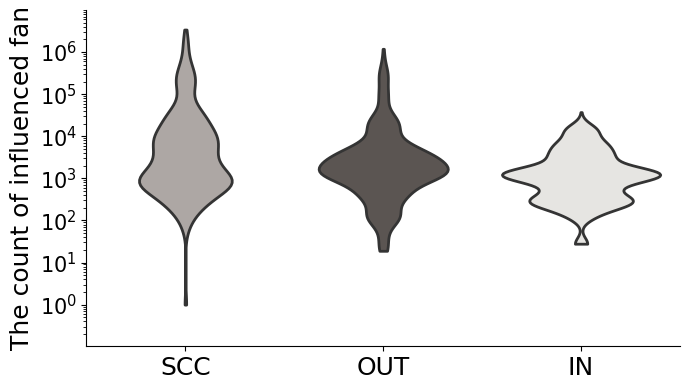

In [91]:
from matplotlib import ticker as mticker
import seaborn as sns

fig, axs = plt.subplots(figsize = (7,4))

# data
my_pal = {"SCC": '#AEA6A3', "IN": "#E7E5E1", "OUT": "#5D5450"}
#sns.stripplot(x = "creator", y="Length", data = within_group, palette = my_pal, size = 6, linewidth = 1, alpha = 0.3)

p = sns.violinplot(x = "creator", y="Length", data = within_group, cut = 0, inner = None, scale = 'area', palette = my_pal, linewidth = 2)

# adjust y axis
axs.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
###axs.yaxis.set_ticks([10**0,  10**1, 10**2, 10**3, 10**4, 10**5, 10**6, 10**7])
ymin, ymax = axs.get_ylim()
print(ymin, ymax)
tick_range = np.arange(np.floor(ymin), ymax)
axs.yaxis.set_ticks(tick_range)
axs.yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
plt.ylim(-0.99, 7)

# label
plt.xticks(fontsize = 18); plt.yticks(fontsize = 15)
plt.xlabel("", fontsize = 15)
plt.ylabel("The count of influenced fan", fontsize = 18)
axs.spines['right'].set_visible(False); axs.spines['top'].set_visible(False)
plt.tight_layout()
#plt.grid('lightgrey', linestyle = '--')

fig.savefig('Figures/SI_SIR_Within.png', dpi = 300, transparent = False)

- **SCC + OUT**

Generate Results

In [ ]:
import pickle

SCC_times = [-3, -2, -1, 0, 1, 2, 3]
OUT_times = [-3, -2, -1, 0, 1, 2, 3]

for i in OUT_times:
    for j in SCC_times:
    
        print("Times: " + "OUT: " + str(i) + " SCC: " + str(j))
        n0_list, epidemic_nodes_list = all_info(G1, 
                                                which_bowtie = 'within_role', 
                                                p_new_bowtie = {'S': 10**j, 'OUT': 10**i, 'IN': 1, 'NA': 1}, 
                                                beta_bowtie = {'S': 0.3, 'OUT': 0.3, 'IN': 0.3, 'NA': 0.3}, 
                                                gamma_bowtie = {'S': 0.2, 'OUT': 0.2,'IN': 0.2, 'NA': 0.2},
                                                iteration = 3000)
    
        with open('Results/SIR_SI/Withingroup-Bowtie/OUT+SCC/OUT10' + str(i) + '-SCC10' + str(j) + '.pickle', 'wb') as file:
            pickle.dump((n0_list, epidemic_nodes_list), file)

Load Results

In [69]:
times = [-3, -2, -1, 0, 1, 2, 3]

var_coeff2_list, expand_coeff2_list, nonexpand_coeff2_list = np.zeros((len(times), len(times))), np.zeros((len(times), len(times))), np.zeros((len(times), len(times)))
var_mi2_list, expand_mi2_list, nonexpand_mi2_list = np.zeros((len(times), len(times))), np.zeros((len(times), len(times))), np.zeros((len(times), len(times)))

for i in times:
    for j in times:
        print("OUT + SCC: ", i, j)
        with open('Results/SIR_SI/Withingroup-Bowtie/OUT+SCC/OUT10' + str(i) + '-SCC10' + str(j) + '.pickle', 'rb') as file:
            n0_list, epidemic_nodes_list = pickle.load(file)
    
        #n0_list, epidemic_nodes_list = list(loaded_dict.keys()), list(loaded_dict.values())
    
        within_group_influ = cal_within_group_influ(n0_list, epidemic_nodes_list)
        
        var_coeff2, var_mi2 = cal_asso_with_fan_var(within_group_influ)
        var_coeff2_list[times.index(i), times.index(j)] = var_coeff2; var_mi2_list[times.index(i), times.index(j)] = var_mi2
        
        #plt.scatter(np.array(list(within_group_influ.values())), size_var)
        #plt.xscale('symlog'); plt.yscale('symlog')
        #plt.show()
    
        expand_coeff2, expand_mi2 = cal_asso_with_fan_expand(within_group_influ)
        expand_coeff2_list[times.index(i), times.index(j)] = expand_coeff2; expand_mi2_list[times.index(i), times.index(j)] = expand_mi2
    
        nonexpand_coeff2, nonexpand_mi2 = cal_asso_with_fan_nonexpand(within_group_influ)
        nonexpand_coeff2_list[times.index(i), times.index(j)] = nonexpand_coeff2; nonexpand_mi2_list[times.index(i), times.index(j)] = nonexpand_mi2

OUT + SCC:  -3 -3
OUT + SCC:  -3 -2
OUT + SCC:  -3 -1
OUT + SCC:  -3 0
OUT + SCC:  -3 1
OUT + SCC:  -3 2
OUT + SCC:  -3 3
OUT + SCC:  -2 -3
OUT + SCC:  -2 -2
OUT + SCC:  -2 -1
OUT + SCC:  -2 0
OUT + SCC:  -2 1
OUT + SCC:  -2 2
OUT + SCC:  -2 3
OUT + SCC:  -1 -3
OUT + SCC:  -1 -2
OUT + SCC:  -1 -1
OUT + SCC:  -1 0
OUT + SCC:  -1 1
OUT + SCC:  -1 2
OUT + SCC:  -1 3
OUT + SCC:  0 -3
OUT + SCC:  0 -2
OUT + SCC:  0 -1
OUT + SCC:  0 0
OUT + SCC:  0 1
OUT + SCC:  0 2
OUT + SCC:  0 3
OUT + SCC:  1 -3
OUT + SCC:  1 -2
OUT + SCC:  1 -1
OUT + SCC:  1 0
OUT + SCC:  1 1
OUT + SCC:  1 2
OUT + SCC:  1 3
OUT + SCC:  2 -3
OUT + SCC:  2 -2
OUT + SCC:  2 -1
OUT + SCC:  2 0
OUT + SCC:  2 1
OUT + SCC:  2 2
OUT + SCC:  2 3
OUT + SCC:  3 -3
OUT + SCC:  3 -2
OUT + SCC:  3 -1
OUT + SCC:  3 0
OUT + SCC:  3 1
OUT + SCC:  3 2
OUT + SCC:  3 3


Plot Results

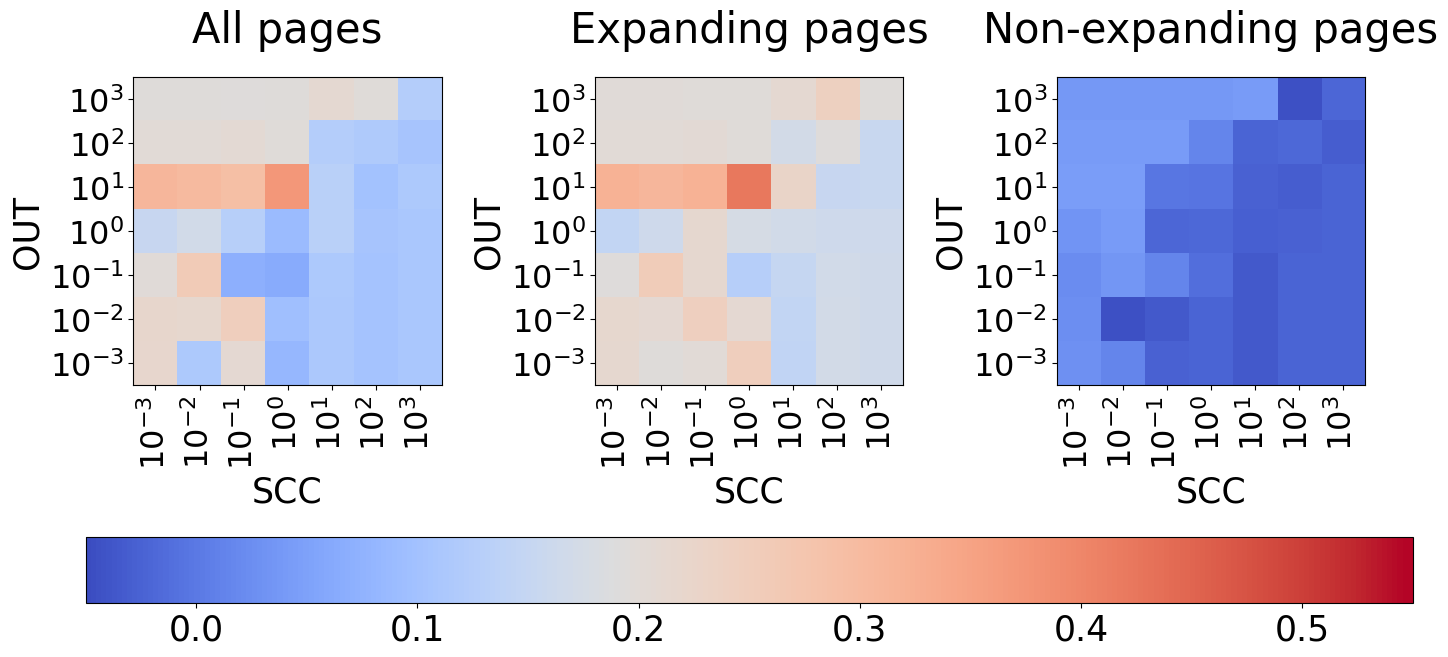

In [70]:
#lower_bound = min(np.min(expand_coeff2_list), np.min(nonexpand_coeff2_list), np.min(var_coeff2_list))
#upper_bound = max(np.max(expand_coeff2_list), np.max(nonexpand_coeff2_list), np.max(var_coeff2_list))

lower_bound = -0.05
upper_bound = 0.55

fig, axs = plt.subplots(1, 3, figsize = (14, 6))
#fig.suptitle('Correlation Coefficient', fontsize = 25)
fig.subplots_adjust(top = 1.1)
fig.tight_layout()

axs[0].matshow(var_coeff2_list, cmap = shifted_cmap, vmin = lower_bound, vmax = upper_bound)
axs[0].set_title('All pages', fontsize = 30, pad = 25)
axs[0].set_ylabel('OUT', fontsize = 25); axs[0].set_xlabel('SCC', fontsize = 25)
axs[0].set_xticks(np.arange(len(times)), label_conversion(times), rotation = 90); axs[0].set_yticks(np.arange(len(times)), label_conversion(times))
axs[0].tick_params(labelsize = 23)
axs[0].xaxis.set_ticks_position('bottom')
axs[0].invert_yaxis()

axs[1].matshow(expand_coeff2_list, cmap = shifted_cmap, vmin = lower_bound, vmax = upper_bound)
axs[1].set_title('Expanding pages', fontsize = 30, pad = 25)
axs[1].set_ylabel('OUT', fontsize = 25); axs[1].set_xlabel('SCC', fontsize = 25)
axs[1].set_xticks(np.arange(len(times)), label_conversion(times), rotation = 90); axs[1].set_yticks(np.arange(len(times)), label_conversion(times))
axs[1].tick_params(labelsize = 23)
axs[1].xaxis.set_ticks_position('bottom')
axs[1].invert_yaxis()

im = axs[2].matshow(nonexpand_coeff2_list, cmap = shifted_cmap, vmin = lower_bound, vmax = upper_bound)
axs[2].set_title('Non-expanding pages', fontsize = 30, pad = 25)
axs[2].set_ylabel('OUT', fontsize = 25); axs[2].set_xlabel('SCC', fontsize = 25)
axs[2].set_xticks(np.arange(len(times)), label_conversion(times), rotation = 90); axs[2].set_yticks(np.arange(len(times)), label_conversion(times))
axs[2].tick_params(labelsize = 23)
axs[2].xaxis.set_ticks_position('bottom')
axs[2].invert_yaxis()

cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink = 1, pad = 0.28, location="bottom")
#cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink = 1.5, pad = 0.08)
cbar.ax.tick_params(labelsize = 25)

plt.savefig('Figures/SI_Withingroup-OUT+SCC-cc.png', transparent = True, dpi = 400)

- **OUT + IN**

Generate Results

In [ ]:
IN_times = [-3, -2, -1, 0, 1, 2, 3]
OUT_times = [-3, -2, -1, 0, 1, 2, 3]

for i in OUT_times:
    for j in SCC_times:
    
        print("Times: " + "OUT: " + str(i) + " SCC: " + str(j))
        n0_list, epidemic_nodes_list = all_info(G1, 
                                                which_bowtie = 'within_role', 
                                                p_new_bowtie = {'S': 1, 'OUT': 10**i, 'IN': 10**j, 'NA': 1}, 
                                                beta_bowtie = {'S': 0.3, 'OUT': 0.3, 'IN': 0.3, 'NA': 0.3}, 
                                                gamma_bowtie = {'S': 0.2, 'OUT': 0.2,'IN': 0.2, 'NA': 0.2},
                                                iteration = 3000)
    
        with open('Results/SIR_SI/Withingroup-Bowtie/OUT+IN/OUT10' + str(i) + '-IN10' + str(j) + '.pickle', 'wb') as file:
            pickle.dump((n0_list, epidemic_nodes_list), file)

Load Results

In [71]:
times = [-3, -2, -1, 0, 1, 2, 3]

var_coeff2_list, expand_coeff2_list, nonexpand_coeff2_list = np.zeros((len(times), len(times))), np.zeros((len(times), len(times))), np.zeros((len(times), len(times)))
var_mi2_list, expand_mi2_list, nonexpand_mi2_list = np.zeros((len(times), len(times))), np.zeros((len(times), len(times))), np.zeros((len(times), len(times)))

for i in times:
    for j in times:
        print("OUT + IN: ", i, j)
        with open('Results/SIR_SI/Withingroup-Bowtie/OUT+IN/OUT10' + str(i) + '-IN10' + str(j) + '.pickle', 'rb') as file:
            n0_list, epidemic_nodes_list = pickle.load(file)
    
        #n0_list, epidemic_nodes_list = list(loaded_dict.keys()), list(loaded_dict.values())
    
        within_group_influ = cal_within_group_influ(n0_list, epidemic_nodes_list)
        
        var_coeff2, var_mi2 = cal_asso_with_fan_var(within_group_influ)
        var_coeff2_list[times.index(i), times.index(j)] = var_coeff2; var_mi2_list[times.index(i), times.index(j)] = var_mi2
        
        #plt.scatter(np.array(list(within_group_influ.values())), size_var)
        #plt.xscale('symlog'); plt.yscale('symlog')
        #plt.show()
    
        expand_coeff2, expand_mi2 = cal_asso_with_fan_expand(within_group_influ)
        expand_coeff2_list[times.index(i), times.index(j)] = expand_coeff2; expand_mi2_list[times.index(i), times.index(j)] = expand_mi2
    
        nonexpand_coeff2, nonexpand_mi2 = cal_asso_with_fan_nonexpand(within_group_influ)
        nonexpand_coeff2_list[times.index(i), times.index(j)] = nonexpand_coeff2; nonexpand_mi2_list[times.index(i), times.index(j)] = nonexpand_mi2
        

OUT + IN:  -3 -3
OUT + IN:  -3 -2
OUT + IN:  -3 -1
OUT + IN:  -3 0
OUT + IN:  -3 1
OUT + IN:  -3 2
OUT + IN:  -3 3
OUT + IN:  -2 -3
OUT + IN:  -2 -2
OUT + IN:  -2 -1
OUT + IN:  -2 0
OUT + IN:  -2 1
OUT + IN:  -2 2
OUT + IN:  -2 3
OUT + IN:  -1 -3
OUT + IN:  -1 -2
OUT + IN:  -1 -1
OUT + IN:  -1 0
OUT + IN:  -1 1
OUT + IN:  -1 2
OUT + IN:  -1 3
OUT + IN:  0 -3
OUT + IN:  0 -2
OUT + IN:  0 -1
OUT + IN:  0 0
OUT + IN:  0 1
OUT + IN:  0 2
OUT + IN:  0 3
OUT + IN:  1 -3
OUT + IN:  1 -2
OUT + IN:  1 -1
OUT + IN:  1 0
OUT + IN:  1 1
OUT + IN:  1 2
OUT + IN:  1 3
OUT + IN:  2 -3
OUT + IN:  2 -2
OUT + IN:  2 -1
OUT + IN:  2 0
OUT + IN:  2 1
OUT + IN:  2 2
OUT + IN:  2 3
OUT + IN:  3 -3
OUT + IN:  3 -2
OUT + IN:  3 -1
OUT + IN:  3 0
OUT + IN:  3 1
OUT + IN:  3 2
OUT + IN:  3 3


Plot Results

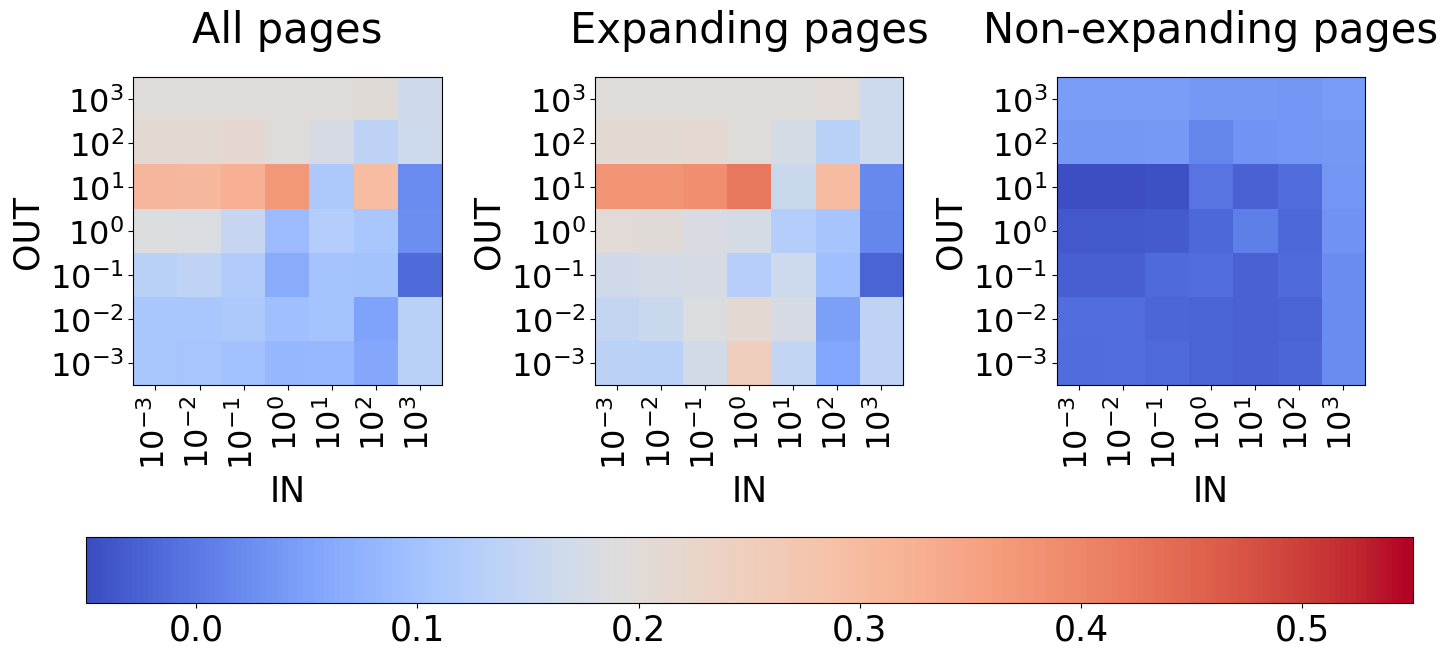

In [72]:
lower_bound = -0.05
upper_bound = 0.55

orig_cmap = matplotlib.cm.coolwarm

fig, axs = plt.subplots(1, 3, figsize = (14, 6))
#fig.suptitle('Correlation Coefficient', fontsize = 25)
fig.subplots_adjust(top = 1.1)
fig.tight_layout()

axs[0].matshow(var_coeff2_list, cmap = shifted_cmap, vmin = lower_bound, vmax = upper_bound)
axs[0].set_title('All pages', fontsize = 30, pad = 25)
axs[0].set_ylabel('OUT', fontsize = 25); axs[0].set_xlabel('IN', fontsize = 25)
axs[0].set_xticks(np.arange(len(times)), label_conversion(times), rotation = 90); axs[0].set_yticks(np.arange(len(times)), label_conversion(times))
axs[0].tick_params(labelsize = 23)
axs[0].xaxis.set_ticks_position('bottom')
axs[0].invert_yaxis()

axs[1].matshow(expand_coeff2_list, cmap = shifted_cmap, vmin = lower_bound, vmax = upper_bound)
axs[1].set_title('Expanding pages', fontsize = 30, pad = 25)
axs[1].set_ylabel('OUT', fontsize = 25); axs[1].set_xlabel('IN', fontsize = 25)
axs[1].set_xticks(np.arange(len(times)), label_conversion(times), rotation = 90); axs[1].set_yticks(np.arange(len(times)), label_conversion(times))
axs[1].tick_params(labelsize = 23)
axs[1].xaxis.set_ticks_position('bottom')
axs[1].invert_yaxis()

im = axs[2].matshow(nonexpand_coeff2_list, cmap = shifted_cmap, vmin = lower_bound, vmax = upper_bound)
axs[2].set_title('Non-expanding pages', fontsize = 30, pad = 25)
axs[2].set_ylabel('OUT', fontsize = 25); axs[2].set_xlabel('IN', fontsize = 25)
axs[2].set_xticks(np.arange(len(times)), label_conversion(times), rotation = 90); axs[2].set_yticks(np.arange(len(times)), label_conversion(times))
axs[2].tick_params(labelsize = 23)
axs[2].xaxis.set_ticks_position('bottom')
axs[2].invert_yaxis()

cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink = 1, pad = 0.28, location="bottom")
#cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink = 1.5, pad = 0.08)
cbar.ax.tick_params(labelsize = 25)

plt.savefig('Figures/SI_Withingroup-OUT+IN-cc.png', transparent = True, dpi = 400)

- **SCC + IN**

Genrate Results

In [ ]:
IN_times = [-3, -2, -1, 0, 1, 2, 3]
SCC_times = [-3, -2, -1, 0, 1, 2, 3]

for i in OUT_times:
    for j in SCC_times:
    
        print("Times: " + "OUT: " + str(i) + " SCC: " + str(j))
        n0_list, epidemic_nodes_list = all_info(G1, 
                                                which_bowtie = 'within_role', 
                                                p_new_bowtie = {'S': 10**i, 'OUT': 1, 'IN': 10**j, 'NA': 1}, 
                                                beta_bowtie = {'S': 0.3, 'OUT': 0.3, 'IN': 0.3, 'NA': 0.3}, 
                                                gamma_bowtie = {'S': 0.2, 'OUT': 0.2,'IN': 0.2, 'NA': 0.2},
                                                iteration = 3000)
    
        with open('Results/SIR_SI/Withingroup-Bowtie/SCC+IN/SCC10' + str(i) + '-IN10' + str(j) + '.pickle', 'wb') as file:
            pickle.dump((n0_list, epidemic_nodes_list), file)

Load Results

In [73]:
times = [-3, -2, -1, 0, 1, 2, 3]

var_coeff2_list, expand_coeff2_list, nonexpand_coeff2_list = np.zeros((len(times), len(times))), np.zeros((len(times), len(times))), np.zeros((len(times), len(times)))
var_mi2_list, expand_mi2_list, nonexpand_mi2_list = np.zeros((len(times), len(times))), np.zeros((len(times), len(times))), np.zeros((len(times), len(times)))

for i in times:
    for j in times:
        print("SCC + IN: ", i, j)
        with open('Results/SIR_SI/Withingroup-Bowtie/SCC+IN/SCC10' + str(i) + '-IN10' + str(j) + '.pickle', 'rb') as file:
            n0_list, epidemic_nodes_list = pickle.load(file)
    
        #n0_list, epidemic_nodes_list = list(loaded_dict.keys()), list(loaded_dict.values())
    
        within_group_influ = cal_within_group_influ(n0_list, epidemic_nodes_list)
        
        var_coeff2, var_mi2 = cal_asso_with_fan_var(within_group_influ)
        var_coeff2_list[times.index(i), times.index(j)] = var_coeff2; var_mi2_list[times.index(i), times.index(j)] = var_mi2
        
        #plt.scatter(np.array(list(within_group_influ.values())), size_var)
        #plt.xscale('symlog'); plt.yscale('symlog')
        #plt.show()
    
        expand_coeff2, expand_mi2 = cal_asso_with_fan_expand(within_group_influ)
        expand_coeff2_list[times.index(i), times.index(j)] = expand_coeff2; expand_mi2_list[times.index(i), times.index(j)] = expand_mi2
    
        nonexpand_coeff2, nonexpand_mi2 = cal_asso_with_fan_nonexpand(within_group_influ)
        nonexpand_coeff2_list[times.index(i), times.index(j)] = nonexpand_coeff2; nonexpand_mi2_list[times.index(i), times.index(j)] = nonexpand_mi2

SCC + IN:  -3 -3
SCC + IN:  -3 -2
SCC + IN:  -3 -1
SCC + IN:  -3 0
SCC + IN:  -3 1
SCC + IN:  -3 2
SCC + IN:  -3 3
SCC + IN:  -2 -3
SCC + IN:  -2 -2
SCC + IN:  -2 -1
SCC + IN:  -2 0
SCC + IN:  -2 1
SCC + IN:  -2 2
SCC + IN:  -2 3
SCC + IN:  -1 -3
SCC + IN:  -1 -2
SCC + IN:  -1 -1
SCC + IN:  -1 0
SCC + IN:  -1 1
SCC + IN:  -1 2
SCC + IN:  -1 3
SCC + IN:  0 -3
SCC + IN:  0 -2
SCC + IN:  0 -1
SCC + IN:  0 0
SCC + IN:  0 1
SCC + IN:  0 2
SCC + IN:  0 3
SCC + IN:  1 -3
SCC + IN:  1 -2
SCC + IN:  1 -1
SCC + IN:  1 0
SCC + IN:  1 1
SCC + IN:  1 2
SCC + IN:  1 3
SCC + IN:  2 -3
SCC + IN:  2 -2
SCC + IN:  2 -1
SCC + IN:  2 0
SCC + IN:  2 1
SCC + IN:  2 2
SCC + IN:  2 3
SCC + IN:  3 -3
SCC + IN:  3 -2
SCC + IN:  3 -1
SCC + IN:  3 0
SCC + IN:  3 1
SCC + IN:  3 2
SCC + IN:  3 3


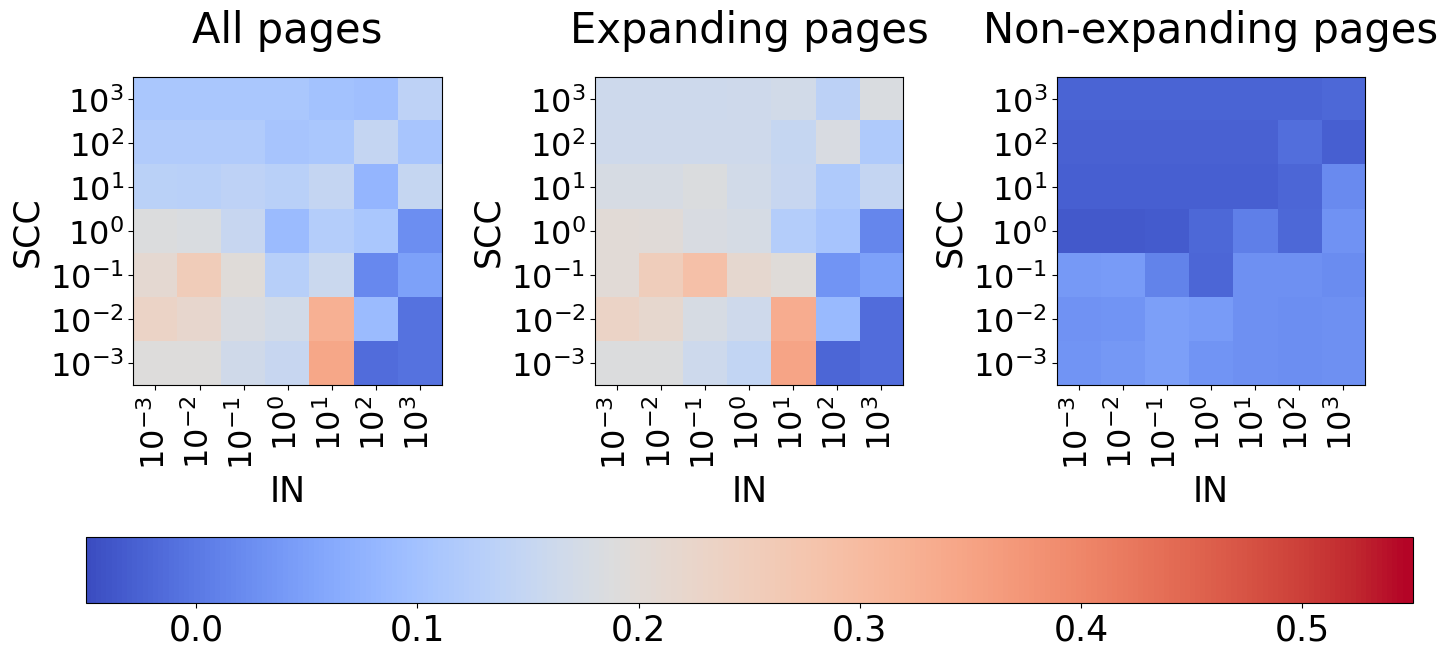

In [74]:
lower_bound = -0.05
upper_bound = 0.55

orig_cmap = matplotlib.cm.coolwarm

fig, axs = plt.subplots(1, 3, figsize = (14, 6))
#fig.suptitle('Correlation Coefficient', fontsize = 25)
fig.subplots_adjust(top = 1.1)
fig.tight_layout()

axs[0].matshow(var_coeff2_list, cmap = shifted_cmap, vmin = lower_bound, vmax = upper_bound)
axs[0].set_title('All pages', fontsize = 30, pad = 25)
axs[0].set_ylabel('SCC', fontsize = 25); axs[0].set_xlabel('IN', fontsize = 25)
axs[0].set_xticks(np.arange(len(times)), label_conversion(times), rotation = 90); axs[0].set_yticks(np.arange(len(times)), label_conversion(times))
axs[0].tick_params(labelsize = 23)
axs[0].xaxis.set_ticks_position('bottom')
axs[0].invert_yaxis()

axs[1].matshow(expand_coeff2_list, cmap = shifted_cmap, vmin = lower_bound, vmax = upper_bound)
axs[1].set_title('Expanding pages', fontsize = 30, pad = 25)
axs[1].set_ylabel('SCC', fontsize = 25); axs[1].set_xlabel('IN', fontsize = 25)
axs[1].set_xticks(np.arange(len(times)), label_conversion(times), rotation = 90); axs[1].set_yticks(np.arange(len(times)), label_conversion(times))
axs[1].tick_params(labelsize = 23)
axs[1].xaxis.set_ticks_position('bottom')
axs[1].invert_yaxis()

im = axs[2].matshow(nonexpand_coeff2_list, cmap = shifted_cmap, vmin = lower_bound, vmax = upper_bound)
axs[2].set_title('Non-expanding pages', fontsize = 30, pad = 25)
axs[2].set_ylabel('SCC', fontsize = 25); axs[2].set_xlabel('IN', fontsize = 25)
axs[2].set_xticks(np.arange(len(times)), label_conversion(times), rotation = 90); axs[2].set_yticks(np.arange(len(times)), label_conversion(times))
axs[2].tick_params(labelsize = 23)
axs[2].xaxis.set_ticks_position('bottom')
axs[2].invert_yaxis()

cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink = 1, pad = 0.28, location="bottom")
#cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink = 1.5, pad = 0.08)
cbar.ax.tick_params(labelsize = 25)

plt.savefig('Figures/SI_Withingroup-SCC+IN-cc.png', transparent = True, dpi = 400)

## 3.2. Across-group Bowtie

- **Info Cascade Length**

In [92]:
across_group = run_model(G1, β = 0.3, ν = 0.2, bowtie = 'across_role', time = 1000)

Running time 1
Running time 2
Running time 3
Running time 4
Running time 5
Running time 6
Running time 7
Running time 8
Running time 9
Running time 10
Running time 11
Running time 12
Running time 13
Running time 14
Running time 15
Running time 16
Running time 17
Running time 18
Running time 19
Running time 20
Running time 21
Running time 22
Running time 23
Running time 24
Running time 25
Running time 26
Running time 27
Running time 28
Running time 29
Running time 30
Running time 31
Running time 32
Running time 33
Running time 34
Running time 35
Running time 36
Running time 37
Running time 38
Running time 39
Running time 40
Running time 41
Running time 42
Running time 43
Running time 44
Running time 45
Running time 46
Running time 47
Running time 48
Running time 49
Running time 50
Running time 51
Running time 52
Running time 53
Running time 54
Running time 55
Running time 56
Running time 57
Running time 58
Running time 59
Running time 60
Running time 61
Running time 62
Running time 63
R

Running time 490
Running time 491
Running time 492
Running time 493
Running time 494
Running time 495
Running time 496
Running time 497
Running time 498
Running time 499
Running time 500
Running time 501
Running time 502
Running time 503
Running time 504
Running time 505
Running time 506
Running time 507
Running time 508
Running time 509
Running time 510
Running time 511
Running time 512
Running time 513
Running time 514
Running time 515
Running time 516
Running time 517
Running time 518
Running time 519
Running time 520
Running time 521
Running time 522
Running time 523
Running time 524
Running time 525
Running time 526
Running time 527
Running time 528
Running time 529
Running time 530
Running time 531
Running time 532
Running time 533
Running time 534
Running time 535
Running time 536
Running time 537
Running time 538
Running time 539
Running time 540
Running time 541
Running time 542
Running time 543
Running time 544
Running time 545
Running time 546
Running time 547
Running time 5

Running time 975
Running time 976
Running time 977
Running time 978
Running time 979
Running time 980
Running time 981
Running time 982
Running time 983
Running time 984
Running time 985
Running time 986
Running time 987
Running time 988
Running time 989
Running time 990
Running time 991
Running time 992
Running time 993
Running time 994
Running time 995
Running time 996
Running time 997
Running time 998
Running time 999
Running time 1000
Running time 1001
Running time 1002
Running time 1003
Running time 1004
Running time 1005
Running time 1006
Running time 1007
Running time 1008
Running time 1009
Running time 1010
Running time 1011
Running time 1012
Running time 1013
Running time 1014
Running time 1015
Running time 1016
Running time 1017
Running time 1018
Running time 1019
Running time 1020
Running time 1021
Running time 1022
Running time 1023
Running time 1024
Running time 1025
Running time 1026
Running time 1027
Running time 1028
Running time 1029
Running time 1030
Running time 1031

Running time 1434
Running time 1435
Running time 1436
Running time 1437
Running time 1438
Running time 1439
Running time 1440
Running time 1441
Running time 1442
Running time 1443
Running time 1444
Running time 1445
Running time 1446
Running time 1447
Running time 1448
Running time 1449
Running time 1450
Running time 1451
Running time 1452
Running time 1453
Running time 1454
Running time 1455
Running time 1456
Running time 1457
Running time 1458
Running time 1459
Running time 1460
Running time 1461
Running time 1462
Running time 1463
Running time 1464
Running time 1465
Running time 1466
Running time 1467
Running time 1468
Running time 1469
Running time 1470
Running time 1471
Running time 1472
Running time 1473
Running time 1474
Running time 1475
Running time 1476
Running time 1477
Running time 1478
Running time 1479
Running time 1480
Running time 1481
Running time 1482
Running time 1483
Running time 1484
Running time 1485
Running time 1486
Running time 1487
Running time 1488
Running ti

Running time 1893
Running time 1894
Running time 1895
Running time 1896
Running time 1897
Running time 1898
Running time 1899
Running time 1900
Running time 1901
Running time 1902
Running time 1903
Running time 1904
Running time 1905
Running time 1906
Running time 1907
Running time 1908
Running time 1909
Running time 1910
Running time 1911
Running time 1912
Running time 1913
Running time 1914
Running time 1915
Running time 1916
Running time 1917
Running time 1918
Running time 1919
Running time 1920
Running time 1921
Running time 1922
Running time 1923
Running time 1924
Running time 1925
Running time 1926
Running time 1927
Running time 1928
Running time 1929
Running time 1930
Running time 1931
Running time 1932
Running time 1933
Running time 1934
Running time 1935
Running time 1936
Running time 1937
Running time 1938
Running time 1939
Running time 1940
Running time 1941
Running time 1942
Running time 1943
Running time 1944
Running time 1945
Running time 1946
Running time 1947
Running ti

Running time 2350
Running time 2351
Running time 2352
Running time 2353
Running time 2354
Running time 2355
Running time 2356
Running time 2357
Running time 2358
Running time 2359
Running time 2360
Running time 2361
Running time 2362
Running time 2363
Running time 2364
Running time 2365
Running time 2366
Running time 2367
Running time 2368
Running time 2369
Running time 2370
Running time 2371
Running time 2372
Running time 2373
Running time 2374
Running time 2375
Running time 2376
Running time 2377
Running time 2378
Running time 2379
Running time 2380
Running time 2381
Running time 2382
Running time 2383
Running time 2384
Running time 2385
Running time 2386
Running time 2387
Running time 2388
Running time 2389
Running time 2390
Running time 2391
Running time 2392
Running time 2393
Running time 2394
Running time 2395
Running time 2396
Running time 2397
Running time 2398
Running time 2399
Running time 2400
Running time 2401
Running time 2402
Running time 2403
Running time 2404
Running ti

Running time 2809
Running time 2810
Running time 2811
Running time 2812
Running time 2813
Running time 2814
Running time 2815
Running time 2816
Running time 2817
Running time 2818
Running time 2819
Running time 2820
Running time 2821
Running time 2822
Running time 2823
Running time 2824
Running time 2825
Running time 2826
Running time 2827
Running time 2828
Running time 2829
Running time 2830
Running time 2831
Running time 2832
Running time 2833
Running time 2834
Running time 2835
Running time 2836
Running time 2837
Running time 2838
Running time 2839
Running time 2840
Running time 2841
Running time 2842
Running time 2843
Running time 2844
Running time 2845
Running time 2846
Running time 2847
Running time 2848
Running time 2849
Running time 2850
Running time 2851
Running time 2852
Running time 2853
Running time 2854
Running time 2855
Running time 2856
Running time 2857
Running time 2858
Running time 2859
Running time 2860
Running time 2861
Running time 2862
Running time 2863
Running ti

In [93]:
across_group['creator'][across_group['creator'] == 'S'] = 'SCC'

In [94]:
min(across_group['Length']), max(across_group['Length'])

(0.0, 3162089.0)

In [95]:
across_group['Length'][across_group['Length'] == 0] = 1

In [96]:
across_group['Length'] = np.log10(across_group['Length'])

In [97]:
across_group['Length'][across_group['Length'] == 0] = -0.8

-1.1649987044699572 6.864972793869099


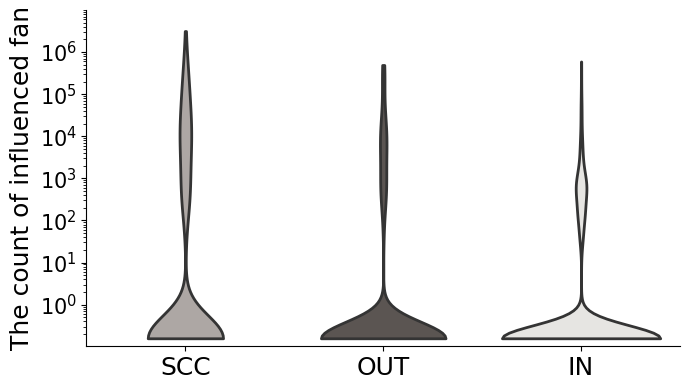

In [98]:
from matplotlib import ticker as mticker
import seaborn as sns

fig, axs = plt.subplots(figsize = (7,4))

# data
#my_pal = {"S": 'tab:red', "IN": "tab:green", "OUT": "tab:blue"}
my_pal = {"SCC": '#AEA6A3', "IN": "#E7E5E1", "OUT": "#5D5450"}
#sns.stripplot(x = "creator", y="Length", data = across_group, palette = my_pal, size = 6, linewidth = 1, alpha = 0.3)
p = sns.violinplot(x = "creator", y="Length", data = across_group, cut = 0, inner = None, scale = 'area', palette = my_pal, linewidth = 2)

# adjust y axis
axs.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
#axs.yaxis.set_ticks([10**0,  10**1, 10**2, 10**3, 10**4, 10**5, 10**6, 10**7])
ymin, ymax = axs.get_ylim()
print(ymin, ymax)
tick_range = np.arange(np.floor(ymin), ymax)
axs.yaxis.set_ticks(tick_range)
axs.yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
plt.ylim(-0.99, 7)

# label
plt.xticks(fontsize = 18); plt.yticks(fontsize = 15)
plt.xlabel("", fontsize = 15)
plt.ylabel("The count of influenced fan", fontsize = 18)
axs.spines['right'].set_visible(False); axs.spines['top'].set_visible(False)
plt.tight_layout()
#plt.grid('lightgrey', linestyle = '--')

fig.savefig('Figures/SI_SIR_Across.png', dpi = 300, transparent = False)

- **OUT + SCC**

Generate Results

In [ ]:
SCC_times = [-3, -2, -1, 0, 1, 2, 3]
OUT_times = [-3, -2, -1, 0, 1, 2, 3]

for i in OUT_times:
    for j in SCC_times:
    
        print("Times: " + "OUT: " + str(i) + " SCC: " + str(j))
        n0_list, epidemic_nodes_list = all_info(G1, 
                                                which_bowtie = 'across_role', 
                                                p_new_bowtie = {'S': 10**j, 'OUT': 10**i, 'IN': 1, 'NA': 1}, 
                                                beta_bowtie = {'S': 0.3, 'OUT': 0.3, 'IN': 0.3, 'NA': 0.3}, 
                                                gamma_bowtie = {'S': 0.2, 'OUT': 0.2,'IN': 0.2, 'NA': 0.2},
                                                iteration = 3000)
    
        with open('Results/SIR_SI/Acrossgroup-Bowtie/OUT+SCC/OUT10' + str(i) + '-SCC10' + str(j) + '.pickle', 'wb') as file:
            pickle.dump((n0_list, epidemic_nodes_list), file)

Load Results

In [75]:
times = [-3, -2, -1, 0, 1, 2, 3]

var_coeff2_list, expand_coeff2_list, nonexpand_coeff2_list = np.zeros((len(times), len(times))), np.zeros((len(times), len(times))), np.zeros((len(times), len(times)))
var_mi2_list, expand_mi2_list, nonexpand_mi2_list = np.zeros((len(times), len(times))), np.zeros((len(times), len(times))), np.zeros((len(times), len(times)))

for i in times:
    for j in times:
        print("OUT + SCC: ", i, j)
        with open('Results/SIR_SI/Acrossgroup-Bowtie/OUT+SCC/OUT10' + str(i) + '-SCC10' + str(j) + '.pickle', 'rb') as file:
            n0_list, epidemic_nodes_list = pickle.load(file)
    
        #n0_list, epidemic_nodes_list = list(loaded_dict.keys()), list(loaded_dict.values())
    
        across_group_influ = cal_across_group_influ(n0_list, epidemic_nodes_list)
    
        var_coeff2, var_mi2 = cal_asso_with_fan_var(across_group_influ)
        var_coeff2_list[times.index(i), times.index(j)] = var_coeff2; var_mi2_list[times.index(i), times.index(j)] = var_mi2
    
        expand_coeff2, expand_mi2 = cal_asso_with_fan_expand(across_group_influ)
        expand_coeff2_list[times.index(i), times.index(j)] = expand_coeff2; expand_mi2_list[times.index(i), times.index(j)] = expand_mi2
    
        nonexpand_coeff2, nonexpand_mi2 = cal_asso_with_fan_nonexpand(across_group_influ)
        nonexpand_coeff2_list[times.index(i), times.index(j)] = nonexpand_coeff2; nonexpand_mi2_list[times.index(i), times.index(j)] = nonexpand_mi2

OUT + SCC:  -3 -3
OUT + SCC:  -3 -2
OUT + SCC:  -3 -1
OUT + SCC:  -3 0
OUT + SCC:  -3 1
OUT + SCC:  -3 2
OUT + SCC:  -3 3
OUT + SCC:  -2 -3
OUT + SCC:  -2 -2
OUT + SCC:  -2 -1
OUT + SCC:  -2 0
OUT + SCC:  -2 1
OUT + SCC:  -2 2
OUT + SCC:  -2 3
OUT + SCC:  -1 -3
OUT + SCC:  -1 -2
OUT + SCC:  -1 -1
OUT + SCC:  -1 0
OUT + SCC:  -1 1
OUT + SCC:  -1 2
OUT + SCC:  -1 3
OUT + SCC:  0 -3
OUT + SCC:  0 -2
OUT + SCC:  0 -1
OUT + SCC:  0 0
OUT + SCC:  0 1
OUT + SCC:  0 2
OUT + SCC:  0 3
OUT + SCC:  1 -3
OUT + SCC:  1 -2
OUT + SCC:  1 -1
OUT + SCC:  1 0
OUT + SCC:  1 1
OUT + SCC:  1 2
OUT + SCC:  1 3
OUT + SCC:  2 -3
OUT + SCC:  2 -2
OUT + SCC:  2 -1
OUT + SCC:  2 0
OUT + SCC:  2 1
OUT + SCC:  2 2
OUT + SCC:  2 3
OUT + SCC:  3 -3
OUT + SCC:  3 -2
OUT + SCC:  3 -1
OUT + SCC:  3 0
OUT + SCC:  3 1
OUT + SCC:  3 2
OUT + SCC:  3 3


Plot Results

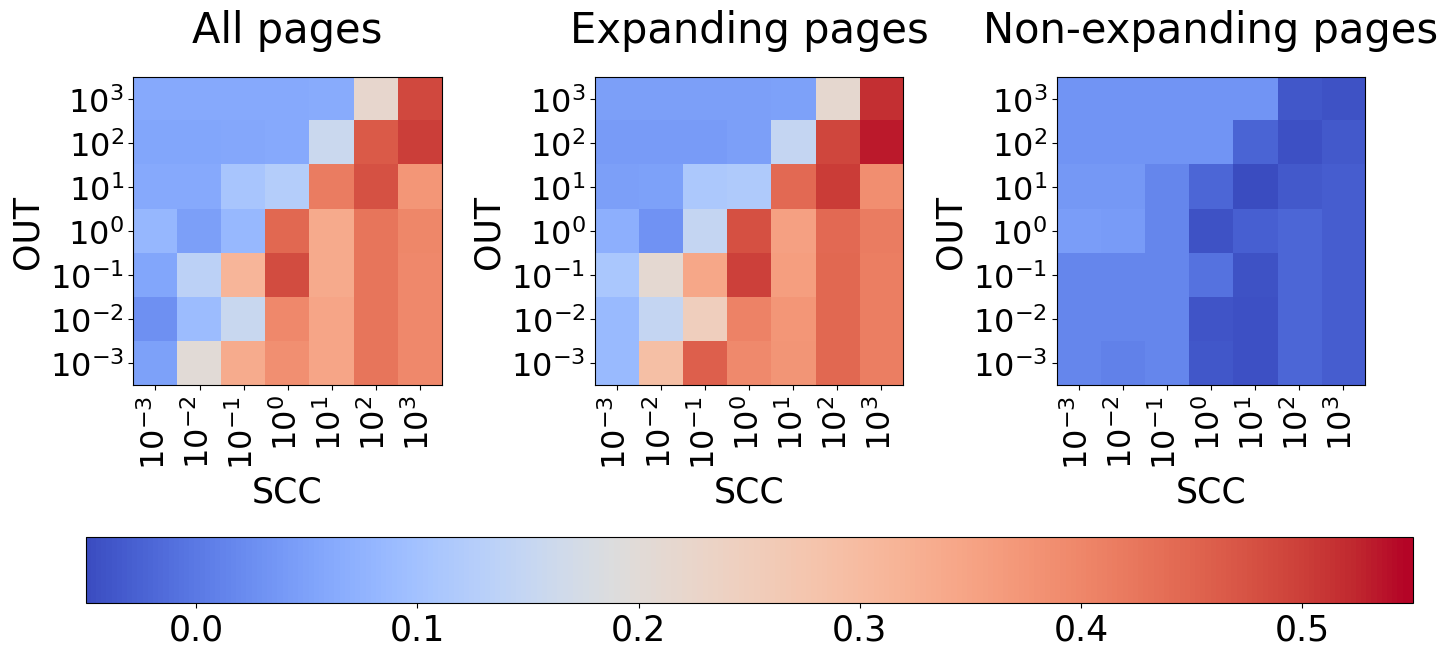

In [76]:
lower_bound = -0.05
upper_bound = 0.55

fig, axs = plt.subplots(1, 3, figsize = (14, 6))
#fig.suptitle('Correlation Coefficient', fontsize = 25)
fig.subplots_adjust(top = 1.1)
fig.tight_layout()

axs[0].matshow(var_coeff2_list, cmap = shifted_cmap, vmin = lower_bound, vmax = upper_bound)
axs[0].set_title('All pages', fontsize = 30, pad = 25)
axs[0].set_ylabel('OUT', fontsize = 25); axs[0].set_xlabel('SCC', fontsize = 25)
axs[0].set_xticks(np.arange(len(times)), label_conversion(times), rotation = 90); axs[0].set_yticks(np.arange(len(times)), label_conversion(times))
axs[0].tick_params(labelsize = 23)
axs[0].xaxis.set_ticks_position('bottom')
axs[0].invert_yaxis()

axs[1].matshow(expand_coeff2_list, cmap = shifted_cmap, vmin = lower_bound, vmax = upper_bound)
axs[1].set_title('Expanding pages', fontsize = 30, pad = 25)
axs[1].set_ylabel('OUT', fontsize = 25); axs[1].set_xlabel('SCC', fontsize = 25)
axs[1].set_xticks(np.arange(len(times)), label_conversion(times), rotation = 90); axs[1].set_yticks(np.arange(len(times)), label_conversion(times))
axs[1].tick_params(labelsize = 23)
axs[1].xaxis.set_ticks_position('bottom')
axs[1].invert_yaxis()

im = axs[2].matshow(nonexpand_coeff2_list, cmap = shifted_cmap, vmin = lower_bound, vmax = upper_bound)
axs[2].set_title('Non-expanding pages', fontsize = 30, pad = 25)
axs[2].set_ylabel('OUT', fontsize = 25); axs[2].set_xlabel('SCC', fontsize = 25)
axs[2].set_xticks(np.arange(len(times)), label_conversion(times), rotation = 90); axs[2].set_yticks(np.arange(len(times)), label_conversion(times))
axs[2].tick_params(labelsize = 23)
axs[2].xaxis.set_ticks_position('bottom')
axs[2].invert_yaxis()

cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink = 1, pad = 0.28, location="bottom")
#cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink = 1.5, pad = 0.08)
cbar.ax.tick_params(labelsize = 25)

plt.savefig('Figures/SI_Acrossgroup-OUT+SCC-cc.png', transparent = True, dpi = 400)

- **OUT + IN**

Generate Results

In [ ]:
OUT_times = [-3, -2, -1, 0, 1, 2, 3]
IN_times = [-3, -2, -1, 0, 1, 2, 3]

for i in OUT_times:
    for j in IN_times:
    
        print("Times: " + "OUT: " + str(i) + " IN: " + str(j))
        n0_list, epidemic_nodes_list = all_info(G1, 
                                                which_bowtie = 'across_role', 
                                                p_new_bowtie = {'S': 1, 'OUT': 10**i, 'IN': 10**j, 'NA': 1}, 
                                                beta_bowtie = {'S': 0.3, 'OUT': 0.3, 'IN': 0.3, 'NA': 0.3}, 
                                                gamma_bowtie = {'S': 0.2, 'OUT': 0.2,'IN': 0.2, 'NA': 0.2},
                                                iteration = 3000)
    
        with open('Results/SIR_SI/Acrossgroup-Bowtie/OUT+IN/OUT10' + str(i) + '-IN10' + str(j) + '.pickle', 'wb') as file:
            pickle.dump((n0_list, epidemic_nodes_list), file)

Load Results

In [77]:
times = [-3, -2, -1, 0, 1, 2, 3]

var_coeff2_list, expand_coeff2_list, nonexpand_coeff2_list = np.zeros((len(times), len(times))), np.zeros((len(times), len(times))), np.zeros((len(times), len(times)))
var_mi2_list, expand_mi2_list, nonexpand_mi2_list = np.zeros((len(times), len(times))), np.zeros((len(times), len(times))), np.zeros((len(times), len(times)))

for i in times:
    for j in times:
        print("OUT + IN: ", i, j)
        with open('Results/SIR_SI/Acrossgroup-Bowtie/OUT+IN/OUT10' + str(i) + '-IN10' + str(j) + '.pickle', 'rb') as file:
            n0_list, epidemic_nodes_list = pickle.load(file)
    
        #n0_list, epidemic_nodes_list = list(loaded_dict.keys()), list(loaded_dict.values())
    
        across_group_influ = cal_across_group_influ(n0_list, epidemic_nodes_list)
    
        var_coeff2, var_mi2 = cal_asso_with_fan_var(across_group_influ)
        var_coeff2_list[times.index(i), times.index(j)] = var_coeff2; var_mi2_list[times.index(i), times.index(j)] = var_mi2
    
        expand_coeff2, expand_mi2 = cal_asso_with_fan_expand(across_group_influ)
        expand_coeff2_list[times.index(i), times.index(j)] = expand_coeff2; expand_mi2_list[times.index(i), times.index(j)] = expand_mi2
    
        nonexpand_coeff2, nonexpand_mi2 = cal_asso_with_fan_nonexpand(across_group_influ)
        nonexpand_coeff2_list[times.index(i), times.index(j)] = nonexpand_coeff2; nonexpand_mi2_list[times.index(i), times.index(j)] = nonexpand_mi2

OUT + IN:  -3 -3
OUT + IN:  -3 -2
OUT + IN:  -3 -1
OUT + IN:  -3 0
OUT + IN:  -3 1
OUT + IN:  -3 2
OUT + IN:  -3 3
OUT + IN:  -2 -3
OUT + IN:  -2 -2
OUT + IN:  -2 -1
OUT + IN:  -2 0
OUT + IN:  -2 1
OUT + IN:  -2 2
OUT + IN:  -2 3
OUT + IN:  -1 -3
OUT + IN:  -1 -2
OUT + IN:  -1 -1
OUT + IN:  -1 0
OUT + IN:  -1 1
OUT + IN:  -1 2
OUT + IN:  -1 3
OUT + IN:  0 -3
OUT + IN:  0 -2
OUT + IN:  0 -1
OUT + IN:  0 0
OUT + IN:  0 1
OUT + IN:  0 2
OUT + IN:  0 3
OUT + IN:  1 -3
OUT + IN:  1 -2
OUT + IN:  1 -1
OUT + IN:  1 0
OUT + IN:  1 1
OUT + IN:  1 2
OUT + IN:  1 3
OUT + IN:  2 -3
OUT + IN:  2 -2
OUT + IN:  2 -1
OUT + IN:  2 0
OUT + IN:  2 1
OUT + IN:  2 2
OUT + IN:  2 3
OUT + IN:  3 -3
OUT + IN:  3 -2
OUT + IN:  3 -1
OUT + IN:  3 0
OUT + IN:  3 1
OUT + IN:  3 2
OUT + IN:  3 3


Plot Results

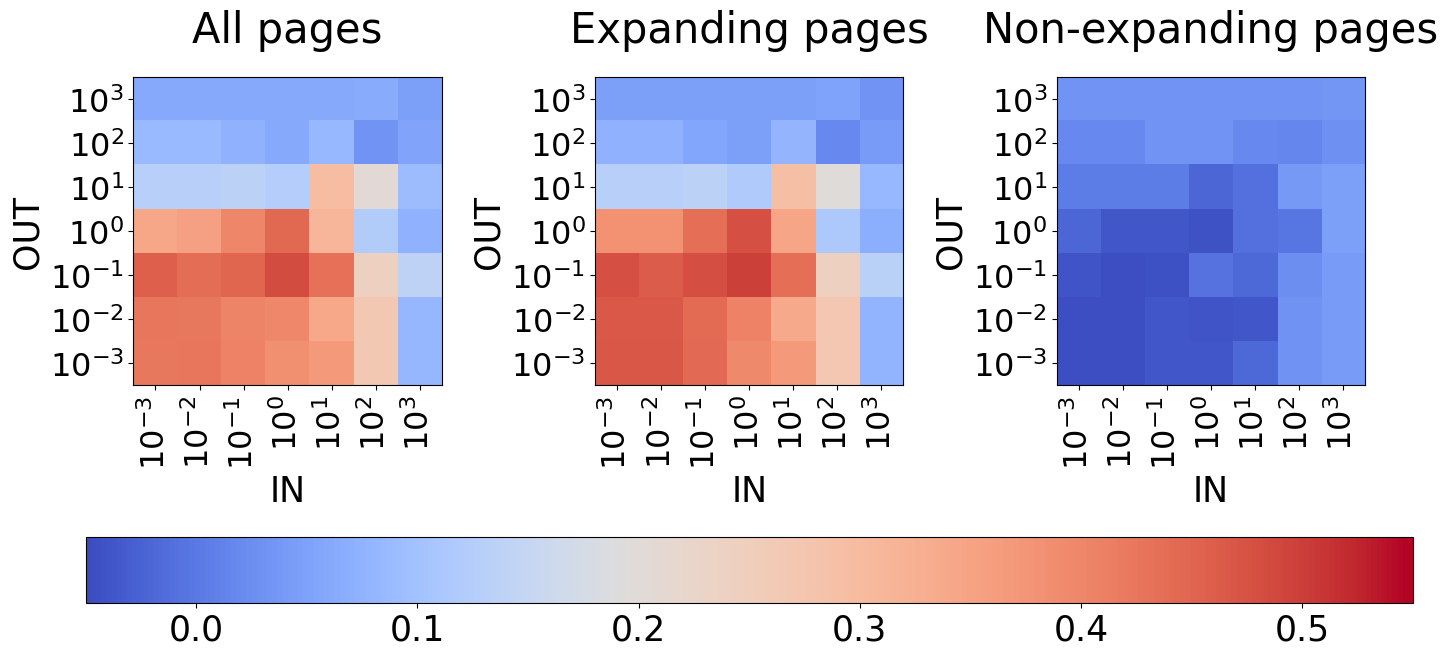

In [78]:
lower_bound = -0.05
upper_bound = 0.55

fig, axs = plt.subplots(1, 3, figsize = (14, 6))
#fig.suptitle('Correlation Coefficient', fontsize = 25)
fig.subplots_adjust(top = 1.1)
fig.tight_layout()

axs[0].matshow(var_coeff2_list, cmap = shifted_cmap, vmin = lower_bound, vmax = upper_bound)
axs[0].set_title('All pages', fontsize = 30, pad = 25)
axs[0].set_ylabel('OUT', fontsize = 25); axs[0].set_xlabel('IN', fontsize = 25)
axs[0].set_xticks(np.arange(len(times)), label_conversion(times), rotation = 90); axs[0].set_yticks(np.arange(len(times)), label_conversion(times))
axs[0].tick_params(labelsize = 23)
axs[0].xaxis.set_ticks_position('bottom')
axs[0].invert_yaxis()

axs[1].matshow(expand_coeff2_list, cmap = shifted_cmap, vmin = lower_bound, vmax = upper_bound)
axs[1].set_title('Expanding pages', fontsize = 30, pad = 25)
axs[1].set_ylabel('OUT', fontsize = 25); axs[1].set_xlabel('IN', fontsize = 25)
axs[1].set_xticks(np.arange(len(times)), label_conversion(times), rotation = 90); axs[1].set_yticks(np.arange(len(times)), label_conversion(times))
axs[1].tick_params(labelsize = 23)
axs[1].xaxis.set_ticks_position('bottom')
axs[1].invert_yaxis()

im = axs[2].matshow(nonexpand_coeff2_list, cmap = shifted_cmap, vmin = lower_bound, vmax = upper_bound)
axs[2].set_title('Non-expanding pages', fontsize = 30, pad = 25)
axs[2].set_ylabel('OUT', fontsize = 25); axs[2].set_xlabel('IN', fontsize = 25)
axs[2].set_xticks(np.arange(len(times)), label_conversion(times), rotation = 90); axs[2].set_yticks(np.arange(len(times)), label_conversion(times))
axs[2].tick_params(labelsize = 23)
axs[2].xaxis.set_ticks_position('bottom')
axs[2].invert_yaxis()

cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink = 1, pad = 0.28, location="bottom")
#cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink = 1.5, pad = 0.08)
cbar.ax.tick_params(labelsize = 25)

plt.savefig('Figures/SI_Acrossgroup-OUT+IN-cc.png', transparent = True, dpi = 400)

- **SCC + IN**

Generate Results

In [ ]:
SCC_times = [-3, -2, -1, 0, 1, 2, 3]
IN_times = [-3, -2, -1, 0, 1, 2, 3]

for i in SCC_times:
    for j in IN_times:
    
        print("Times: " + "SCC: " + str(i) + " IN: " + str(j))
        n0_list, epidemic_nodes_list = all_info(G1, 
                                                which_bowtie = 'across_role', 
                                                p_new_bowtie = {'S': 10**i, 'OUT': 1, 'IN': 10**j, 'NA': 1}, 
                                                beta_bowtie = {'S': 0.3, 'OUT': 0.3, 'IN': 0.3, 'NA': 0.3}, 
                                                gamma_bowtie = {'S': 0.2, 'OUT': 0.2,'IN': 0.2, 'NA': 0.2},
                                                iteration = 3000)
    
        with open('Results/SIR_SI/Acrossgroup-Bowtie/SCC+IN/SCC10' + str(i) + '-IN10' + str(j) + '.pickle', 'wb') as file:
            pickle.dump((n0_list, epidemic_nodes_list), file)

Load Results

In [79]:
times = [-3, -2, -1, 0, 1, 2, 3]

var_coeff2_list, expand_coeff2_list, nonexpand_coeff2_list = np.zeros((len(times), len(times))), np.zeros((len(times), len(times))), np.zeros((len(times), len(times)))
var_mi2_list, expand_mi2_list, nonexpand_mi2_list = np.zeros((len(times), len(times))), np.zeros((len(times), len(times))), np.zeros((len(times), len(times)))

for i in times:
    for j in times:
        print("SCC + IN: ", i, j)
        with open('Results/SIR_SI/Acrossgroup-Bowtie/SCC+IN/SCC10' + str(i) + '-IN10' + str(j) + '.pickle', 'rb') as file:
            n0_list, epidemic_nodes_list = pickle.load(file)
    
        #n0_list, epidemic_nodes_list = list(loaded_dict.keys()), list(loaded_dict.values())
    
        across_group_influ = cal_across_group_influ(n0_list, epidemic_nodes_list)
    
        var_coeff2, var_mi2 = cal_asso_with_fan_var(across_group_influ)
        var_coeff2_list[times.index(i), times.index(j)] = var_coeff2; var_mi2_list[times.index(i), times.index(j)] = var_mi2
    
        expand_coeff2, expand_mi2 = cal_asso_with_fan_expand(across_group_influ)
        expand_coeff2_list[times.index(i), times.index(j)] = expand_coeff2; expand_mi2_list[times.index(i), times.index(j)] = expand_mi2
    
        nonexpand_coeff2, nonexpand_mi2 = cal_asso_with_fan_nonexpand(across_group_influ)
        nonexpand_coeff2_list[times.index(i), times.index(j)] = nonexpand_coeff2; nonexpand_mi2_list[times.index(i), times.index(j)] = nonexpand_mi2

SCC + IN:  -3 -3
SCC + IN:  -3 -2
SCC + IN:  -3 -1
SCC + IN:  -3 0
SCC + IN:  -3 1
SCC + IN:  -3 2
SCC + IN:  -3 3
SCC + IN:  -2 -3
SCC + IN:  -2 -2
SCC + IN:  -2 -1
SCC + IN:  -2 0
SCC + IN:  -2 1
SCC + IN:  -2 2
SCC + IN:  -2 3
SCC + IN:  -1 -3
SCC + IN:  -1 -2
SCC + IN:  -1 -1
SCC + IN:  -1 0
SCC + IN:  -1 1
SCC + IN:  -1 2
SCC + IN:  -1 3
SCC + IN:  0 -3
SCC + IN:  0 -2
SCC + IN:  0 -1
SCC + IN:  0 0
SCC + IN:  0 1
SCC + IN:  0 2
SCC + IN:  0 3
SCC + IN:  1 -3
SCC + IN:  1 -2
SCC + IN:  1 -1
SCC + IN:  1 0
SCC + IN:  1 1
SCC + IN:  1 2
SCC + IN:  1 3
SCC + IN:  2 -3
SCC + IN:  2 -2
SCC + IN:  2 -1
SCC + IN:  2 0
SCC + IN:  2 1
SCC + IN:  2 2
SCC + IN:  2 3
SCC + IN:  3 -3
SCC + IN:  3 -2
SCC + IN:  3 -1
SCC + IN:  3 0
SCC + IN:  3 1
SCC + IN:  3 2
SCC + IN:  3 3


Plot Results

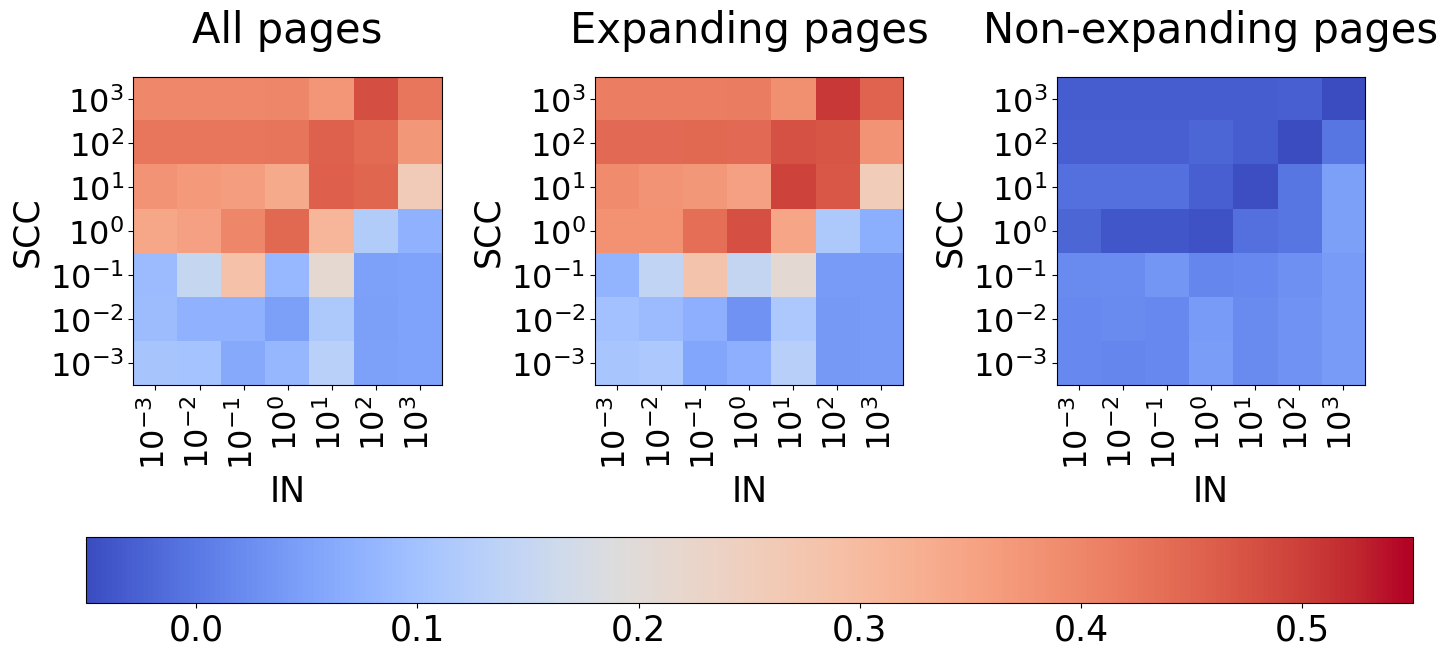

In [80]:
lower_bound = -0.05
upper_bound = 0.55

fig, axs = plt.subplots(1, 3, figsize = (14, 6))
#fig.suptitle('Correlation Coefficient', fontsize = 25)
fig.subplots_adjust(top = 1.1)
fig.tight_layout()

axs[0].matshow(var_coeff2_list, cmap = shifted_cmap, vmin = lower_bound, vmax = upper_bound)
axs[0].set_title('All pages', fontsize = 30, pad = 25)
axs[0].set_ylabel('SCC', fontsize = 25); axs[0].set_xlabel('IN', fontsize = 25)
axs[0].set_xticks(np.arange(len(times)), label_conversion(times), rotation = 90); axs[0].set_yticks(np.arange(len(times)), label_conversion(times))
axs[0].tick_params(labelsize = 23)
axs[0].xaxis.set_ticks_position('bottom')
axs[0].invert_yaxis()

axs[1].matshow(expand_coeff2_list, cmap = shifted_cmap, vmin = lower_bound, vmax = upper_bound)
axs[1].set_title('Expanding pages', fontsize = 30, pad = 25)
axs[1].set_ylabel('SCC', fontsize = 25); axs[1].set_xlabel('IN', fontsize = 25)
axs[1].set_xticks(np.arange(len(times)), label_conversion(times), rotation = 90); axs[1].set_yticks(np.arange(len(times)), label_conversion(times))
axs[1].tick_params(labelsize = 23)
axs[1].xaxis.set_ticks_position('bottom')
axs[1].invert_yaxis()

im = axs[2].matshow(nonexpand_coeff2_list, cmap = shifted_cmap, vmin = lower_bound, vmax = upper_bound)
axs[2].set_title('Non-expanding pages', fontsize = 30, pad = 25)
axs[2].set_ylabel('SCC', fontsize = 25); axs[2].set_xlabel('IN', fontsize = 25)
axs[2].set_xticks(np.arange(len(times)), label_conversion(times), rotation = 90); axs[2].set_yticks(np.arange(len(times)), label_conversion(times))
axs[2].tick_params(labelsize = 23)
axs[2].xaxis.set_ticks_position('bottom')
axs[2].invert_yaxis()

cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink = 1, pad = 0.28, location="bottom")
#cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink = 1.5, pad = 0.08)
cbar.ax.tick_params(labelsize = 25)

plt.savefig('Figures/SI_Acrossgroup-SCC+IN-cc.png', transparent = True, dpi = 400)